In [1]:
!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [4]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

In [5]:
#@title create dataset
from detectron2.data.detection_utils import read_image
from transformers import AutoImageProcessor

#processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
#processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
#processor = AutoProcessor.from_pretrained("facebook/vit-mae-large")
#processor = AutoProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
#processor.do_center_crop = False

target_mean = [0.485, 0.456, 0.406]
target_std = [0.229, 0.224, 0.225]
processor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=target_mean, std=target_std)])

class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        # self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'
        self.segmentation_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/segmentations/' # change folder path on your local machine

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y

/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data indices:  [5238, 2316]
data indices:  [5275, 2395, 5238, 2316]
[np.int64(175), np.int64(79), np.int64(174), np.int64(77)]


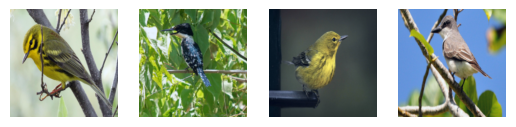

0 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/176.Prairie_Warbler/Prairie_Warbler_0086_172534.jpg
1 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/080.Green_Kingfisher/Green_Kingfisher_0037_71113.jpg
2 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/175.Pine_Warbler/Pine_Warbler_0010_171239.jpg
3 /mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/images/078.Gray_Kingbird/Gray_Kingbird_0045_70256.jpg


In [6]:
#@title dataset and dataloader and load samples

import random
from detectron2.data.detection_utils import read_image
query_transforms = Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomPerspective(distortion_scale=0.25, p=1.0),
        torchvision.transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
        ])

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
base_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/' # change folder path on your local machine

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

NUMBER_OF_PROTOTYPES = 2

random.seed(501)
# inputs, labels, masks = [], [], []
inputs, labels = [], []
#data_indices = []
data_indices = random.sample(range(train_dataset.__len__()), NUMBER_OF_PROTOTYPES)
print("data indices: ", data_indices)
data_indices.insert(0, 2395)
data_indices.insert(0, 5275)
# data_indices.insert(0, 1028)
# data_indices.insert(0, 5260)
# data_indices.insert(0, 912)
# data_indices.insert(0, 925)
# data_indices.insert(0, 2335)
# data_indices.insert(0, 5253)
# data_indices.insert(0, 5250)
# data_indices.insert(0, 1024)
# data_indices.insert(0, 1028)
#data_indices.insert(0, 16)
#data_indices = [153, 151, 213, 244]
print("data indices: ", data_indices)

for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)
  # masks.append(mask)

print(labels)

plt.figure(1)
plt.subplot(141)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(142)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(143)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.subplot(144)
plt.imshow(imsc(inputs[3]))
plt.axis('off')
plt.show()


# The image initializations in VLPart is different. We need to use read_image function
vlpart_inputs = []
file_inputs = []
for counter, data_idx in enumerate(data_indices):
    # print(counter,data_idx)
    vlpart_x = ''.join([base_path, 'images/', train_dataset.filenames.iloc[data_idx, 1]])
    image_path = ''.join([base_path, 'images/', train_dataset.filenames.iloc[data_idx, 1]])
    file_inputs.append(image_path)
    print(counter,vlpart_x)
    vlpart_x = read_image(''.join([base_path, 'images/', train_dataset.filenames.iloc[data_idx, 1]]), format="BGR")
    vlpart_inputs.append(vlpart_x)

In [7]:
#@title load model


from transformers import AutoProcessor, CLIPVisionModel, Dinov2Model, ViTMAEModel, ViTModel

#model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')
#model = ViTMAEModel.from_pretrained("facebook/vit-mae-large", attn_implementation="eager").to('cuda')
#model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", attn_implementation="eager").to('cuda')


In [8]:
#@title create patch embeddings

IMG_SIZE = x.shape[-1]
print("image size:", IMG_SIZE)

device='cuda'

embedings = []
heatmaps = []

#embedings.append(model.encoder(model.get_input_embeddings()(input_i)).last_hidden_state[0, :, :].numpy(force=True)) MAE thing

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)

        outputs = model(input_i, output_attentions=True)

        #embedings.append(model.visual_projection(outputs.last_hidden_state[0, 1:, :]).numpy(force=True))
        embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))

        heatmaps.append(outputs.attentions[0].mean(1)[:, 0, 1:].numpy(force=True))

NUMBER_OF_PATCHES = outputs.last_hidden_state[0, 1:, :].shape[0]
SQRT_NUMBER_OF_PATCHES = int(np.sqrt(NUMBER_OF_PATCHES))
STRIDE = model.config.patch_size #model.get_submodule('embeddings').get_submodule('patch_embeddings').get_submodule('projection').stride[0]
PATCH_SIZE = model.config.patch_size
print("patch size:", PATCH_SIZE)
NUMBER_OF_PATCHES_X = NUMBER_OF_PATCHES_Y = int(IMG_SIZE / PATCH_SIZE)
print("number of patches:", NUMBER_OF_PATCHES)
print("number of patches x:", NUMBER_OF_PATCHES_X)
print("number of patches y:", NUMBER_OF_PATCHES_Y)
LATENT_DIM = embedings[0].shape[-1]

image size: 224


Dinov2Model is using Dinov2SdpaSelfAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


patch size: 14
number of patches: 256
number of patches x: 16
number of patches y: 16


In [9]:
import glob
import multiprocessing as mp
import numpy as np
import os
import tempfile
import time
import warnings
import cv2
import tqdm
import argparse

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
import sys
from VLPart.vlpart.config import add_vlpart_config
from VLPart.demo.predictor import VisualizationDemo
from detectron2.config import CfgNode

DEFAULT_CONFIG_FILE = "/mnt/d/Github/SuperpixelCUB/VLPart/configs/pascal_part/r50_pascalpart.yaml"
DEFAULT_WEIGHTS = "/mnt/d/Github/SuperpixelCUB/VLPart/checkpoints/r50_pascalpart.pth"
DEFAULT_CONFIDENCE_THRESHOLD = 0.7
# CUSTOM_VOCABULARY =  ["bird beak", "bird head", "bird eye","bird leg", "bird foot", "bird wing", "bird neck", "bird tail","bird torso" ]
# CUSTOM_VOCABULARY = ["bird:back", "bird:head", "bird:foot", "bird:neck", "bird:beak", "bird:belly", "bird:breast", "bird:crown", "bird:eye", "bird:wing", "bird:nape", "bird:leg", "bird:torso", "bird:tail"]
CUSTOM_VOCABULARY = "bird back, bird head, bird foot, bird neck, bird beak, bird belly, bird breast, bird crown, bird eye, bird wing, bird nape, bird leg, bird torso, bird tail"
DEFAULT_OUTPUT_PATH = "/mnt/d/Github/SuperpixelCUB/output/custom_vocabulary/"

def get_parser():
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input",
        nargs="+",
        help="A list of space separated input images; "
        "or a single glob pattern such as 'directory/*.jpg'",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )
    parser.add_argument(
        "--vocabulary",
        default="pascal_part",
        choices=['pascal_part', 'partimagenet', 'paco',
                 'voc', 'coco', 'lvis',
                 'pascal_part_voc', 'lvis_paco', 'custom'],
        help="",
    )
    parser.add_argument(
        "--custom_vocabulary",
        default="",
        help="",
    )
    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.5,
        help="Minimum score for instance predictions to be shown",
    )

    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    return parser


def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_vlpart_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.MODEL.WEIGHTS = DEFAULT_WEIGHTS
    cfg.merge_from_list(['VIS.BOX', 'False'])
    # cfg.merge_from_list(args.opts)
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = DEFAULT_CONFIDENCE_THRESHOLD
    cfg.freeze()
    return cfg

mp.set_start_method("spawn", force=True)
args = get_parser().parse_args([])
args.config_file = DEFAULT_CONFIG_FILE
args.custom_vocabulary = CUSTOM_VOCABULARY
args.vocabulary = "custom"
args.confidence_threshold  = DEFAULT_CONFIDENCE_THRESHOLD
setup_logger(name="fvcore")
logger = setup_logger()
logger.info("Arguments: " + str(args))
cfg = setup_cfg(args)


[03/31 08:53:49 detectron2]: Arguments: Namespace(config_file='/mnt/d/Github/SuperpixelCUB/VLPart/configs/pascal_part/r50_pascalpart.yaml', webcam=False, video_input=None, input=None, output=None, vocabulary='custom', custom_vocabulary='bird back, bird head, bird foot, bird neck, bird beak, bird belly, bird breast, bird crown, bird eye, bird wing, bird nape, bird leg, bird torso, bird tail', confidence_threshold=0.7, opts=[])


In [10]:
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

In [11]:
import requests


def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

# def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
#     masks = masks.cpu().float()
#     masks = masks.permute(0, 2, 3, 1)
#     masks = masks.mean(axis=-1)
#     masks = (masks > 0).int()
#     masks = masks.numpy().astype(np.uint8)
#     masks = list(masks)

#     if polygon_refinement:
#         for idx, mask in enumerate(masks):
#             shape = mask.shape
#             polygon = mask_to_polygon(mask)
#             mask = polygon_to_mask(polygon, shape)
#             masks[idx] = mask

#     return masks

def refine_masks(refined_masks: dict, polygon_refinement: bool = False) -> dict:
    if polygon_refinement:
        for label, mask in refined_masks.items():
            polygon = mask_to_polygon(mask)
            refined_masks[label] = polygon_to_mask(polygon, mask.shape)
    return refined_masks


In [12]:
from VLPart.demo.predictor import VisualizationDemo
from detectron2.data.detection_utils import read_image
from detectron2.utils.visualizer import ColorMode, Visualizer, GenericMask
from collections import defaultdict
from detectron2.data import MetadataCatalog

def get_class_names(dataset_name):
    class_names_dict = {}
    if dataset_name == "custom":
        for i, name in enumerate(CUSTOM_VOCABULARY.split(",")):
            class_names_dict[i] = name.strip()
        print("---custom class names:", class_names_dict)
    else:
        # Load the metadata for the dataset
        class_names_dict = {}
        metadata = MetadataCatalog.get(dataset_name)
        for i, name in enumerate(metadata.thing_classes):
            class_names_dict[i] = name       
    # print("class names:", class_names_dict)
    return class_names_dict

def refine_masks_by_semantics(semantic_groups, score_threshold=0.5):
    refined_masks = {}

    for label, mask_score_list in semantic_groups.items():
        # Sort masks by confidence descending
        sorted_masks = sorted(mask_score_list, key=lambda x: x[1], reverse=True)

        refined_mask = np.zeros_like(sorted_masks[0][0], dtype=np.uint8)
        confidence_map = np.zeros_like(refined_mask, dtype=np.float32)

        for mask, score in sorted_masks:
            if score < score_threshold:
                continue  # Skip low-confidence masks

            # Update only pixels with higher score than existing ones
            update_pixels = (mask & (score > confidence_map))
            refined_mask[update_pixels] = 1
            confidence_map[update_pixels] = score

        refined_masks[label] = refined_mask

    return refined_masks

def process_images(cfg):
    
    vlpart_refined_masks = []
    demo = VisualizationDemo(cfg)
    # for input_img in tqdm.tqdm(vlpart_inputs):
    for i, (input_img, file_path) in enumerate(zip(vlpart_inputs, file_inputs)):
        # img = read_image(path, format="BGR")
        start_time = time.time()
        predictions, visualized_output = demo.run_on_image(input_img)
        
        basename = os.path.splitext(os.path.basename(file_path))[0]
        print("basename:", basename)
        # create a folder for the current image
        output_dir = os.path.join(DEFAULT_OUTPUT_PATH, basename)
        os.makedirs(output_dir, exist_ok=True)

        if "instances" in predictions:
            pred_instances = predictions["instances"]
            pred_masks = pred_instances.pred_masks.to("cpu").numpy()
            pred_classes = pred_instances.pred_classes.to("cpu").numpy()
            pred_scores = pred_instances.scores.to("cpu").numpy()
            
            semantic_groups = defaultdict(list)
            vocabulary_dict = get_class_names("custom")
            # vocabulary_dict = get_class_names("pascal_part_val")
            
            for mask, cls, score in zip(pred_masks, pred_classes, pred_scores):
                pred_label = vocabulary_dict.get(cls, f"class_{cls}")
                semantic_groups[pred_label].append((mask, score))

            refined_masks = refine_masks_by_semantics(semantic_groups, score_threshold=0.55)
            
            vlpart_refined_masks.append(refined_masks)
            # save refined masks separately per semantic class
            for label, refined_mask in refined_masks.items():
                mask_img = (refined_mask * 255).astype(np.uint8)
                mask_filename = os.path.join(output_dir, f"{basename}_{label}.png")
                cv2.imwrite(mask_filename, mask_img)

        # save the visualized output
        out_filename = os.path.join(output_dir, f"{basename}_vis.jpg")
        visualized_output.save(out_filename)
    
    return vlpart_refined_masks
        
vlpart_final_masks = process_images(cfg)


Freezing Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Freezing Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size

/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_lo

WARNING [03/31 08:53:52 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.base.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.0.bn3.num_batches_tracked
backbone.bottom_up.base.layer1.0.downsample.1.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.1.bn3.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn1.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn2.num_batches_tracked
backbone.bottom_up.base.layer1.2.bn3.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn1.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn2.num_batches_tracked
backbone.bottom_up.base.layer2.0.bn3.num_batches_tracked
backbone.bottom_up.base.layer2.0.downsample.1.num_batches_tracked
backbone.bottom_up.

/home/chensy/anaconda3/envs/vlpart_env/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


basename: Prairie_Warbler_0086_172534
---custom class names: {0: 'bird back', 1: 'bird head', 2: 'bird foot', 3: 'bird neck', 4: 'bird beak', 5: 'bird belly', 6: 'bird breast', 7: 'bird crown', 8: 'bird eye', 9: 'bird wing', 10: 'bird nape', 11: 'bird leg', 12: 'bird torso', 13: 'bird tail'}
basename: Green_Kingfisher_0037_71113
---custom class names: {0: 'bird back', 1: 'bird head', 2: 'bird foot', 3: 'bird neck', 4: 'bird beak', 5: 'bird belly', 6: 'bird breast', 7: 'bird crown', 8: 'bird eye', 9: 'bird wing', 10: 'bird nape', 11: 'bird leg', 12: 'bird torso', 13: 'bird tail'}
basename: Pine_Warbler_0010_171239
---custom class names: {0: 'bird back', 1: 'bird head', 2: 'bird foot', 3: 'bird neck', 4: 'bird beak', 5: 'bird belly', 6: 'bird breast', 7: 'bird crown', 8: 'bird eye', 9: 'bird wing', 10: 'bird nape', 11: 'bird leg', 12: 'bird torso', 13: 'bird tail'}
basename: Gray_Kingbird_0045_70256
---custom class names: {0: 'bird back', 1: 'bird head', 2: 'bird foot', 3: 'bird neck', 4

In [ ]:
print("vlpart_final_masks:", vlpart_final_masks)
print("vlpart_final_masks length:", len(vlpart_final_masks))

def label_to_class_id(label, dataset):
    if dataset != "custom":
        # Load the metadata for the dataset
        metadata = MetadataCatalog.get(dataset)
        print("metadata thing classes:", metadata.thing_classes)
        # build a dictionary of class names with i start from 1
        # class_dict = {i: name for i, name in enumerate(metadata.thing_classes)}
        class_dict = {i: name for i, name in enumerate(metadata.thing_classes, start=1)}
        print("class_dict:", class_dict)
    else:
        class_dict = get_class_names("custom")
    
    # find the class ID based on the label
    class_id = next((idx for idx, name in class_dict.items() if name == label), None)
    
    if class_id is not None:
        return int(class_id)
    else:
        # if label is class_{number} format
        if "_" in label and label.split("_")[-1].isdigit():
            return int(label.split("_")[-1])
        
def get_class_dict(dataset_name):
    if dataset_name == "custom":
        class_dict = {i: name for i, name in enumerate(CUSTOM_VOCABULARY.split(","))}
    else:
        # Load the metadata for the dataset
        metadata = MetadataCatalog.get(dataset_name)
        class_dict = {i: name for i, name in enumerate(metadata.thing_classes)}
    return class_dict

def class_names_to_segmentation_masks(refined_masks):
    segmentation_maps = {}
    for label, mask in refined_masks.items():
        print("label:", label)
        label = label_to_class_id(label, "custom")
        # label = label_to_class_id(label, "pascal_part_val")
        print("label to class id:", label)
        segmentation_maps[label] = mask

    return segmentation_maps

# convert masks to segmentation maps
vlpart_final_segmentations = []
for i in range(len(vlpart_final_masks)):
    vlpart_final_segmentations.append(class_names_to_segmentation_masks(vlpart_final_masks[i]))


vlpart_final_masks: [{'bird crown': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'bird eye': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'class_15': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'bird wing': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'bird torso': array([[0, 0, 0, ..., 0, 0, 0],
     

In [14]:
from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops
import numpy as np
from skimage.transform import resize
# TODO: replace with your own function to get segments -- ok! 
# def get_segments(embedding, mask, number_of_patches: int,
#                  resize_size: int = 64, number_of_segments: int = 8):

#     embedding = embedding.reshape(number_of_patches, number_of_patches, -1)
#     embedding = resize(embedding, (resize_size, resize_size))

#     mask = resize(mask, (resize_size, resize_size), order=0)

#     segments = slic(embedding, n_segments=number_of_segments, mask=mask)

#     return segments



In [15]:
from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops

print("vlpart_final_segmentations:", vlpart_final_segmentations)
resize_size = 64
all_keypoints = []

for embeding, segments_dict in zip(embedings, vlpart_final_segmentations):

    # convert segments_dict to single 2D array
    segments = np.zeros_like(next(iter(segments_dict.values())), dtype=np.int32)
    for label, mask in segments_dict.items():
        # print("label:", label)
        segments[mask.astype(bool)] = label  
    
    embeding = embeding.reshape(NUMBER_OF_PATCHES_X, NUMBER_OF_PATCHES_Y, -1)
    embeding = resize(embeding, (resize_size, resize_size))
    # print("embeding shape:", embeding.shape)
    segments = resize(segments, (resize_size, resize_size), order=0, preserve_range=True).astype(np.int32)

    low_res_keypoints = np.zeros_like(segments, dtype=np.int32)
    props = regionprops(segments)

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        low_res_keypoints[x_coordinate, y_coordinate] = region_i + 1

    keypoints = np.zeros((224, 224), dtype=np.int32)

    high_res_keypoints = resize(low_res_keypoints, (224, 224), order=0, preserve_range=True)
    props = regionprops(high_res_keypoints.astype(np.int32))

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        keypoints[x_coordinate, y_coordinate] = region_i + 1

    all_keypoints.append(np.int32(keypoints))


vlpart_final_segmentations: [{None: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 15: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}, {None: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 15: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 14: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
    

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
# fig, axs = plt.subplots(2, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

# for col_idx, (image_i, segments_i) in enumerate(zip(inputs, all_segments)):

#     axs[0, col_idx].imshow(imsc(image_i))
#     axs[0, col_idx].set_axis_off()

#     axs[1, col_idx].imshow(segments_i)
#     axs[1, col_idx].set_axis_off()

# fig.tight_layout()

fig, axs = plt.subplots(3, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, segments_dict) in enumerate(zip(inputs, vlpart_final_segmentations)):

    axs[0, col_idx].imshow(imsc(image_i))
    axs[0, col_idx].set_axis_off()

    # convert segments_dict to a single 2D label array
    segments_img = np.zeros_like(next(iter(segments_dict.values())), dtype=np.int32)
    for class_id, mask in segments_dict.items():
        segments_img[mask.astype(bool)] = class_id

    
    axs[1, col_idx].imshow(segments_img)
    axs[1, col_idx].set_axis_off()
    
    axs[2, col_idx].imshow(segments_img, cmap='nipy_spectral')
    axs[2, col_idx].set_axis_off()

fig.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import numpy as np

fig, axs = plt.subplots(4, NUMBER_OF_PROTOTYPES + 2, figsize=(12, 6))

for col_idx, (image_i, mask_dict, segmentation_dict) in enumerate(zip(inputs, vlpart_final_masks, vlpart_final_segmentations)):

    # Row 0: original image
    axs[0, col_idx].imshow(imsc(image_i))
    axs[0, col_idx].set_axis_off()

    # Create a label map (single 2D array)
    label_map = np.zeros_like(next(iter(mask_dict.values())), dtype=np.int32)

    label_to_mask_name = {}       # 1: "bird:wing"
    label_to_segment_class = {}   # 1: 8 (class_id)

    for idx, (name, mask) in enumerate(mask_dict.items(), start=1):
        label_map[mask.astype(bool)] = idx
        label_to_mask_name[idx] = name

    for idx, (class_id, mask) in enumerate(segmentation_dict.items(), start=1):
        label_map[mask.astype(bool)] = idx
        label_to_segment_class[idx] = class_id

    # Row 1: plain integer mask
    axs[1, col_idx].imshow(label_map)
    axs[1, col_idx].set_axis_off()

    # Row 2: colored mask with text from mask_dict
    axs[2, col_idx].imshow(label_map, cmap='nipy_spectral')
    axs[2, col_idx].set_axis_off()

    for prop in regionprops(label_map):
        y, x = prop.centroid
        label = prop.label
        label_text = label_to_mask_name.get(label, "unknown")

        axs[2, col_idx].text(x, y, label_text, fontsize=8, color='white',
                             ha='center', va='center',
                             bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.2'))

    # Row 3: colored mask with text from segmentation_dict (class IDs)
    axs[3, col_idx].imshow(label_map, cmap='nipy_spectral')
    axs[3, col_idx].set_axis_off()

    for prop in regionprops(label_map):
        y, x = prop.centroid
        label = prop.label
        label_text = str(label_to_segment_class.get(label, "unknown"))

        axs[3, col_idx].text(x, y, label_text, fontsize=8, color='white',
                             ha='center', va='center',
                             bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.2'))

fig.tight_layout()
plt.show()



In [ ]:
cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"])

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    colors = np.array([cmap(x) for x in range(np.max(keypoints_i))])
    radius1, radius2 = 8, 1

    for keypoint_i, color in zip(np.unique(keypoints_i)[1:], colors):

        y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

        circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=color, edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)

fig.tight_layout()

In [ ]:
# TODO : Check from here! query regions and prototype regions seemed to wrong somewhere

# number_of_query_regions = 0
# number_of_prototype_regions = []
# region_means = []

# for sample_i, sample_i_segments in enumerate(vlpart_final_segmentations):

#     sample_i_region_means = []
#     embeding = embedings[sample_i].reshape(NUMBER_OF_PATCHES_X, NUMBER_OF_PATCHES_Y, -1)
#     embeding = resize(embeding, (resize_size, resize_size)).reshape(-1, LATENT_DIM)

#     if sample_i == 0: number_of_query_regions = np.max(sample_i_segments)
#     else: number_of_prototype_regions.append(np.max(sample_i_segments))

#     for segment_i in np.unique(sample_i_segments)[1:]:

#         segment_i_indices = np.where(sample_i_segments.flatten()==segment_i)[0]
#         sample_i_region_means.append(np.mean(embeding[segment_i_indices], 0))

#     region_means.append(sample_i_region_means)

number_of_query_regions = 0
number_of_prototype_regions = []
region_means = []

resize_size = 64

for sample_i, sample_i_segments_dict in enumerate(vlpart_final_segmentations):

    # Step 1: convert segments_dict to labeled array (original size)
    segments_array = np.zeros_like(next(iter(sample_i_segments_dict.values())), dtype=np.int32)
    for label, mask in sample_i_segments_dict.items():
        segments_array[mask.astype(bool)] = label  
    
    # Step 2: resize segments_array to match embedding size exactly
    segments_array_resized = resize(
        segments_array, 
        (resize_size, resize_size), 
        order=0, 
        preserve_range=True, 
        anti_aliasing=False
    ).astype(np.int32)

    sample_i_region_means = []

    # Step 3: embedding reshape and resize
    embeding = embedings[sample_i].reshape(NUMBER_OF_PATCHES_X, NUMBER_OF_PATCHES_Y, -1)
    embeding_resized = resize(
        embeding, 
        (resize_size, resize_size), 
        anti_aliasing=True, 
        preserve_range=True
    ).reshape(-1, LATENT_DIM)

    if sample_i == 0:
        number_of_query_regions = np.max(segments_array_resized)
    else:
        number_of_prototype_regions.append(np.max(segments_array_resized))

    # Step 4: Compute mean embeddings per segment
    for segment_i in np.unique(segments_array_resized):
        if segment_i == 0:
            continue

        segment_i_indices = np.where(segments_array_resized.flatten() == segment_i)[0]

        if segment_i_indices.size == 0:
            continue

        segment_mean = np.mean(embeding_resized[segment_i_indices], axis=0)
        sample_i_region_means.append(segment_mean)

    print("sample_i_region_means:", sample_i_region_means)
    region_means.append(sample_i_region_means)


In [ ]:


# query_region_means = np.array(region_means[0])

# prototype_region_means = np.concatenate(region_means[1:])

# nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(query_region_means, prototype_region_means, axis=1, metric='cosine')
# nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(query_region_means, prototype_region_means, axis=0, metric='cosine')

# best_buddies_query = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_query_regions)
# best_buddies_prototypes = nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_prototype_regions))

# best_buddies_query_indices = nearest_neighbor_query[best_buddies_query]
# best_buddies_prototypes_indices = nearest_neighbor_prototypes[best_buddies_prototypes]

# print(best_buddies_query)
# print(best_buddies_prototypes)

# best_buddies_query_indices = np.where(nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_query_regions))[0]
# best_buddies_prototypes_indices = np.where(nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_prototype_regions)))[0]

from sklearn.metrics import pairwise_distances_argmin_min

query_region_means = np.array(region_means[0])
prototype_region_means = np.concatenate(region_means[1:])

# query to prototype closest region
nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(
    query_region_means, prototype_region_means, metric='cosine'
)

# prototype to query closest region
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(
    prototype_region_means, query_region_means, metric='cosine'
)

# best buddies judge
best_buddies_query = np.zeros(len(query_region_means), dtype=bool)
for query_idx, proto_idx in enumerate(nearest_neighbor_query):
    # check whether prototype closest region also matches the query closest region
    if nearest_neighbor_prototypes[proto_idx] == query_idx:
        best_buddies_query[query_idx] = True

best_buddies_prototypes = np.zeros(len(prototype_region_means), dtype=bool)
for proto_idx, query_idx in enumerate(nearest_neighbor_prototypes):
    if nearest_neighbor_query[query_idx] == proto_idx:
        best_buddies_prototypes[proto_idx] = True

# extract best buddies indices
best_buddies_query_indices = np.where(best_buddies_query)[0]
best_buddies_prototypes_indices = np.where(best_buddies_prototypes)[0]

print("best_buddies_query:", best_buddies_query)
print("best_buddies_prototypes:", best_buddies_prototypes)




In [ ]:
print(best_buddies_query_indices)
print(np.nonzero(best_buddies_query)[0])
print(np.arange(number_of_query_regions)[np.nonzero(best_buddies_query)[0]])
#np.arange(number_of_query_regions)[np.nonzero(best_buddies_query)[0]]

print(np.nonzero(best_buddies_prototypes)[0])
print(np.arange(np.sum(number_of_prototype_regions))[np.nonzero(best_buddies_prototypes)[0]])

In [ ]:
# # cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
# #                     "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
# cmap = ListedColormap([
#     "red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
#     "maroon", "black", "white", "chocolate", "gray", "blueviolet",
#     "olive", "teal", "navy", "coral", "plum", "pink", "gold", "brown", "turquoise", "orchid"
# ])

# # colors = np.array([cmap(x) for x in range(15)])
# colors = np.array([cmap(x) for x in range(cmap.N)])

# mnn_matches = {}

# print("all keypoints:", all_keypoints)
# fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

# for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

#     #print('Sample', col_idx)
#     #print(50*'-')

#     axs[col_idx].imshow(imsc(image_i))
#     axs[col_idx].set_axis_off()

#     radius1, radius2 = 8, 1

#     for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

#         if col_idx == 0:
#           if not best_buddies_query[keypoint_i-1]: continue
#         elif col_idx == 1:
#           if not best_buddies_prototypes[keypoint_i-1]: continue
#         else:
#           if not best_buddies_prototypes[np.sum(number_of_prototype_regions[:(col_idx-1)])+keypoint_i-1]: continue

#         if col_idx == 0:
#           color_value = keypoint_counter
#           mnn_matches[keypoint_i-1] = color_value
#         elif col_idx == 1:
#           color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
#         else:
#           color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_prototype_regions[:(col_idx-1)])+keypoint_i-1]]

        
#         y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

#         circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
#         circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
#         axs[col_idx].add_patch(circ1_1)
#         axs[col_idx].add_patch(circ1_2)


# fig.tight_layout()

cmap = ListedColormap([
    "red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
    "maroon", "black", "white", "chocolate", "gray", "blueviolet",
    "olive", "teal", "navy", "coral", "plum", "pink", "gold", "brown", "turquoise", "orchid"
])
colors = np.array([cmap(x) for x in range(cmap.N)])


fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES + 2, figsize=(10, 5))

# create a dictionary to store the color mapping for each keypoint
mnn_matches = {}

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    radius1, radius2 = 8, 1

    # use the unique keypoint（not 0）
    unique_kps = np.unique(keypoints_i)
    unique_kps = unique_kps[unique_kps > 0]

    for keypoint_counter, keypoint_id in enumerate(unique_kps):

        # Check if the keypoint is a best buddy and index is valid
        if col_idx == 0:
            if keypoint_counter >= len(best_buddies_query) or not best_buddies_query[keypoint_counter]:
                continue
        elif col_idx == 1:
            if keypoint_counter >= len(best_buddies_prototypes) or not best_buddies_prototypes[keypoint_counter]:
                continue
        else:
            global_index = np.sum(number_of_prototype_regions[:(col_idx - 1)]) + keypoint_counter
            if global_index >= len(best_buddies_prototypes) or not best_buddies_prototypes[global_index]:
                continue

        # Determine the color value based on the column index
        if col_idx == 0:
            color_value = keypoint_counter
            mnn_matches[keypoint_id] = color_value
        elif col_idx == 1:
            color_value = mnn_matches.get(nearest_neighbor_prototypes[keypoint_counter], 0)
        else:
            global_index = np.sum(number_of_prototype_regions[:(col_idx - 1)]) + keypoint_counter
            neighbor_idx = nearest_neighbor_prototypes[global_index]
            color_value = mnn_matches.get(neighbor_idx, 0)

        # get keypoint coordinates
        y_coordinate, x_coordinate = np.where(keypoints_i == keypoint_id)

        if len(x_coordinate) == 0 or len(y_coordinate) == 0:
            continue  # avoid empty coordinates

        # draw circles
        circ1_1 = plt.Circle((x_coordinate[0], y_coordinate[0]), radius1,
                             facecolor=colors[color_value], edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate[0], y_coordinate[0]), radius2,
                             facecolor=colors[color_value], edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)

fig.tight_layout()
plt.show()


In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

cmap = ListedColormap([
    "red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
    "maroon", "black", "white", "chocolate", "gray", "blueviolet",
    "olive", "teal", "navy", "coral", "plum", "pink", "gold", "brown", "turquoise", "orchid"
])
colors = np.array([cmap(x) for x in range(cmap.N)])

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES + 2, figsize=(10, 5))
mnn_matches = {}

# TODO : Check this part! Keypoints are not matching with the masks
for col_idx, (image_i, keypoints_mask, keypoints_labels_dict) in enumerate(zip(inputs, all_keypoints, vlpart_final_masks)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    radius1, radius2 = 8, 1
    unique_kps = np.unique(keypoints_mask)
    unique_kps = unique_kps[unique_kps > 0]  # filter out background

    label_keys = list(keypoints_labels_dict.keys())  # textual labels from mask dict

    for keypoint_counter, keypoint_id in enumerate(unique_kps):

        # --- Buddy check ---
        if col_idx == 0:
            if keypoint_counter >= len(best_buddies_query) or not best_buddies_query[keypoint_counter]:
                continue
        elif col_idx == 1:
            if keypoint_counter >= len(best_buddies_prototypes) or not best_buddies_prototypes[keypoint_counter]:
                continue
        else:
            global_index = np.sum(number_of_prototype_regions[:(col_idx - 1)]) + keypoint_counter
            if global_index >= len(best_buddies_prototypes) or not best_buddies_prototypes[global_index]:
                continue

        # --- Color selection ---
        if col_idx == 0:
            color_value = keypoint_counter
            mnn_matches[keypoint_id] = color_value
        elif col_idx == 1:
            color_value = mnn_matches.get(nearest_neighbor_prototypes[keypoint_counter], 0)
        else:
            global_index = np.sum(number_of_prototype_regions[:(col_idx - 1)]) + keypoint_counter
            neighbor_idx = nearest_neighbor_prototypes[global_index]
            color_value = mnn_matches.get(neighbor_idx, 0)

        # --- Keypoint coords --- 
        y_coords, x_coords = np.where(keypoints_mask == keypoint_id)
        if len(x_coords) == 0 or len(y_coords) == 0:
            continue
        mean_x, mean_y = np.mean(x_coords), np.mean(y_coords)

        # --- Draw circle ---
        circ1 = plt.Circle((mean_x, mean_y), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
        circ2 = plt.Circle((mean_x, mean_y), radius2, facecolor=colors[color_value], edgecolor='white')
        axs[col_idx].add_patch(circ1)
        axs[col_idx].add_patch(circ2)

        # --- Draw label ---
        label_text = label_keys[keypoint_counter] if keypoint_counter < len(label_keys) else 'unknown'
        axs[col_idx].text(mean_x + 5, mean_y - 5, label_text, fontsize=8, color='white',
                          bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.2'))

fig.tight_layout()
plt.show()
